In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np

import os
from matplotlib.gridspec import GridSpec

import matplotlib as mpl
mpl.rcParams['font.serif'] = "Bitstream Vera Serif"
mpl.rcParams['font.family'] = "serif"
mpl.rcParams['font.size'] = 18

from numpy import polyfit,polyval

In [2]:
def flatten_and_mask_shots(shots, mask,):
    num_shots = shots.shape[0]
    size = shots.shape[1]*shots.shape[2]
    flat_mask = mask.reshape(size)
    flat_shots =  shots.reshape( (num_shots,size))*flat_mask
    
    return flat_shots[:,flat_mask]

def unflatten_shots(flat_shots,mask):
    num_shots = flat_shots.shape[0]
    shape = mask.shape
    flat_mask = mask.reshape(shape[0]*shape[1]
                            )
    shots = np.zeros( (num_shots,shape[0]*shape[1]), dtype = flat_shots.dtype)
    shots[:, flat_mask ] = flat_shots
    
    return shots.reshape( (num_shots,shape[0],shape[1]))

In [3]:
f = h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/flatfield_calibration/calibrated_shots/run73_shots_cali.h5','r')
f.keys()
num_shots = f['cali_single_shots_15'].shape[0]
calibrated_ave_shot = f['cali_single_shots_15'].value.mean(0)

f = h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/flatfield_calibration/flat_det_imgs/fullImgs_run73.h5','r')
print f.keys()
ave_shots = f['flat_img'][:num_shots].mean(0)
ave_int_per_shot = f['flat_img'][:num_shots].mean(-1)

mask=np.load('/reg/d/psdm/cxi/cxilr6716/results/masks/basic_psana_mask.npy')

[u'ave_tot_int', u'ebeam', u'event_time', u'evr', u'fiducials', u'flat_img', u'gas_detector', u'phase_cav']


In [4]:
f = h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/flatfield_calibration/calibrated_shots/run76_shots_cali.h5','r')
print f.keys()
num_shots = f['cali_single_shots_15'].shape[0]
calibrated_ave_shot = f['cali_single_shots_15'].value.mean(0)

f = h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/flatfield_calibration/flat_det_imgs/fullImgs_run76.h5','r')
print f.keys()
ave_shots = f['flat_img'][:num_shots].mean(0)
ave_int_per_shot = f['flat_img'][:num_shots].mean(-1)


[u'cali_single_shots_10', u'cali_single_shots_15', u'cali_single_shots_20', u'cali_single_shots_5']
[u'ave_tot_int', u'ebeam', u'event_time', u'evr', u'fiducials', u'flat_img', u'gas_detector', u'phase_cav']


In [5]:
print num_shots

300


In [6]:
full_ave_shots = unflatten_shots(ave_shots[None,:],mask)[0]

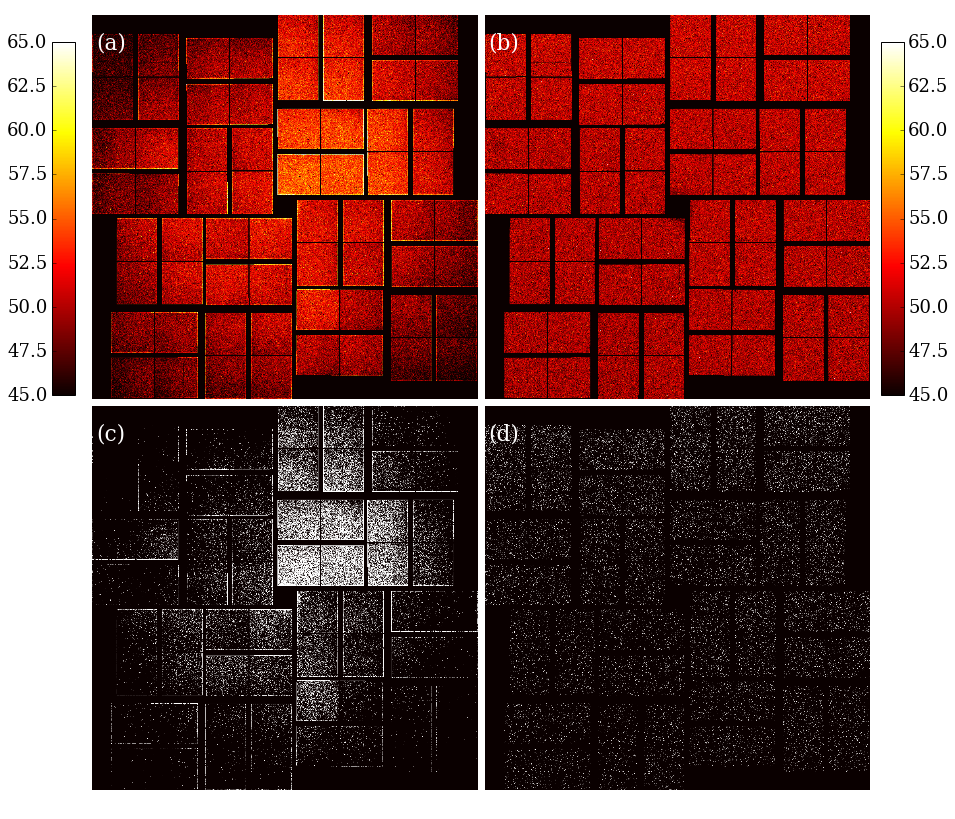

In [7]:
# idx = 10

# shot_to_plot=shots[idx]
mu=ave_shots.mean()
sigma=ave_shots.std()

x = 45
y= 65
gs = GridSpec(2,2)
gs.update(hspace=0.0, wspace=0.02)
####raw ave shot
fig = plt.figure(figsize=[16,14])

ax=plt.subplot(gs[0,0])
im=plt.imshow( full_ave_shots, 
         aspect=1, cmap='hot',vmin=x,vmax=y)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.09, 0.52, 0.02, 0.35])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')

ax.set_title('(a)', x= 0.05,y =0.9, color='White')
ax.set_axis_off()

#### calibrated average shot
ax=plt.subplot(gs[0,1])

im = plt.imshow( calibrated_ave_shot, 
         aspect=1, cmap='hot',vmin=x,vmax=y)
ax.set_title('(b)', x= 0.05,y =0.9, color='White')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.52, 0.02, 0.35])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('right')

ax.set_axis_off()
#### large intensities
ax=plt.subplot(gs[1,0])

large_int_plot=full_ave_shots>(mu+sigma)
plt.imshow( large_int_plot, 
         aspect=1, cmap='hot',vmin=0,vmax=1)
ax.set_title('(c)', x= 0.05,y =0.9, color='White')
ax.set_axis_off()

### after calibrations
ax=plt.subplot(gs[1,1])

large_int_plot=calibrated_ave_shot>(mu+sigma)
plt.imshow( large_int_plot, 
         aspect=1, cmap='hot',vmin=0,vmax=1)
ax.set_title('(d)', x= 0.05,y =0.9, color='White')
ax.set_axis_off()

# print mu, sigma
# plt.colorbar()
# plt.savefig('copper_flatfield_aveADU_%.2f.png'% ave_int_per_shot.mean(),bbox_in_inches='tight')

In [8]:
print mu, sigma

50.1987 3.28812


In [10]:
img=flatten_and_mask_shots(calibrated_ave_shot[None,:],mask)[0]
bins = np.linspace(x-10,y,100)
hist = np.histogram(img,bins=bins)
hist2 = np.histogram(ave_shots,bins=bins)

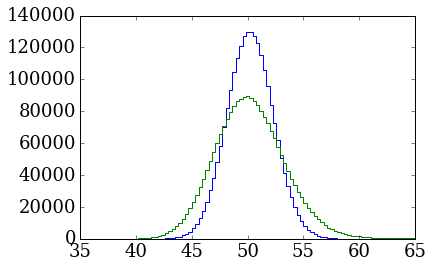

In [11]:
plt.step(bins[1:],hist[0])
plt.step(bins[1:],hist2[0])

In [12]:
runs =[72,73,76,78,71,80,81]
n_shots=[]
cali_rps=[]
rps=[]
for rr in runs:
    f=h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/polar_data/run%d_0.h5'%rr,'r')
    rp=f['radial_profs'].value.mean(0)
    rps.append(rp)
    
    f=h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/cali_polar_data/run%d_0.h5'%rr,'r')
    rp=f['radial_profs'].value.mean(0)
    
    x = range(f['radial_profs'].shape[-1])

    fit=polyval(polyfit(x,rp,deg=15),x)
    res = np.abs(fit-rp).mean(0)
    mm = np.abs(fit-rp)>res

    rp[mm] = 0
    
    #filter
    cali_rps.append(rp)
    
    n_shots.append(f['radial_profs'].shape[0])
rps = np.array(rps)
cali_rps = np.array(cali_rps)
n_shots = np.array(n_shots)

In [13]:
ints = rps.mean(-1)

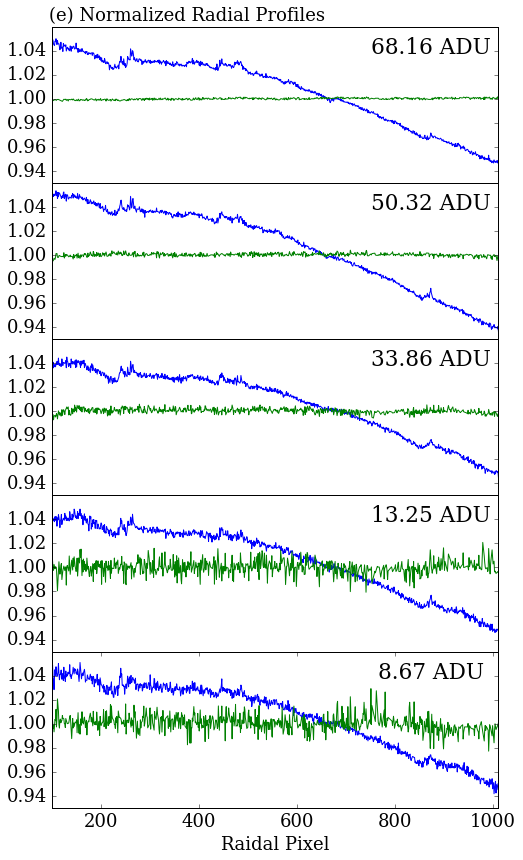

In [27]:
fig=plt.figure(figsize=[8,14])
gs = GridSpec(5,1)
gs.update(hspace=0)
x = np.arange(100,rps.shape[-1]+100)
#     if idx==0:
plt.suptitle('(e) Normalized Radial Profiles',x=0.36,y=0.92,
            fontsize=18)

for idx,ii in enumerate([1,2,3,5,6]):
    ax = plt.subplot(gs[idx,0])
#     if ii ==1:
#         ax.set_title('(e)', x= 0.34,y =0.9, color='Black')

    plt.plot(x,rps[ii]/rps[ii].mean(),'b-')
#     plt.plot(x,rps[ii],'b-')
    mm= cali_rps[ii]>0
    plt.plot(x[mm],cali_rps[ii][mm]/cali_rps[ii][mm].mean(),'g-')
    plt.ylim(0.93,1.06)
    plt.xlim(100,1010)
    if idx<4:
        plt.xticks([])
    plt.yticks([0.94,0.96,0.98,1.0,1.02,1.04])
    ax.set_title('%.2f ADU'%ints[ii], x= 0.85,y =0.8, color='black')

#     plt.ylabel('R. P.')
    
plt.xlabel('Raidal Pixel')
plt.savefig('copper_flatfield_RPs_e.png',bbox_in_inches='tight')